## Baseline classification results for catinous

In [260]:
from pytorch_lightning import Trainer
#from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
import catinous.CatsinomModelGramCache as catsmodel
import catinous.utils as cutils
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
from py_jotools import mut, cache
import SimpleITK as sitk
import pydicom as pyd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

# Loading test sets

In [3]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_lr_dataset.csv', split='test'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_hr_dataset.csv', split='test'), batch_size=8, num_workers=4)
device = torch.device('cuda')

## Testing LR model

Read: /project/catinous/trained_models/batch_lr_train-base_train_1_ff8d796f2c.pt


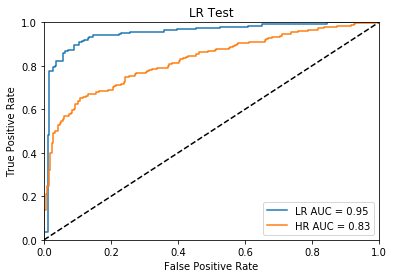

In [4]:
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache, weights_file = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR')

## Testing LR-base model

Read: /project/catinous/trained_models/batch_lr_base_train_1_2d20289ac9.pt


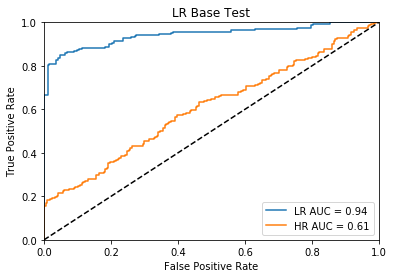

In [5]:
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache, weights_file = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR Base')

## Testing HR Model

Read: /project/catinous/trained_models/batch_hr_train-base_train_1_157f172f1b.pt


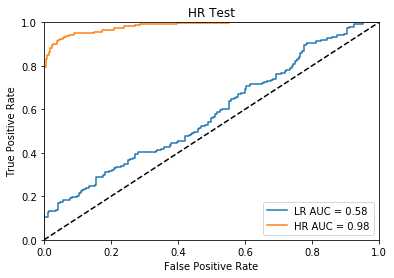

In [6]:
hparams={'continous':False,
         'datasetfile': 'catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache, _ = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR')

## Testing HR-base model

Read: /project/catinous/trained_models/batch_hr_base_train_1_98bf44d0f0.pt


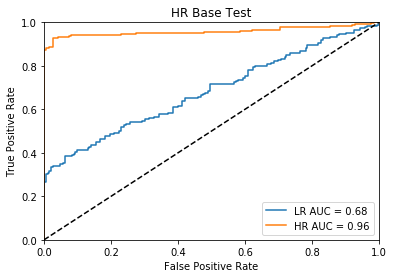

In [7]:
hparams={'continous':False,
         'datasetfile': 'catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache, _ = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR Base')

## Testing combined model

Read: /project/catinous/trained_models/batch_combined_train-base_train_1_f25aa3238b.pt


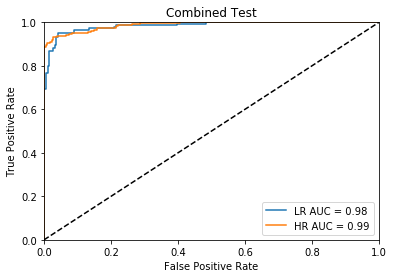

In [8]:
hparams={'continous':False,
         'datasetfile': 'catsinom_combined_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000,
         'val_check_interval': 3000}
model, logs, df_cache, _ = catsmodel.trained_model(hparams, show_progress=True)
model = model.to(device) #not sure why this is needed, model should be on device
plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='Combined')

## Testing LR-HR

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': 'batch_lr_train-base_train_1_013cced594.pt',
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


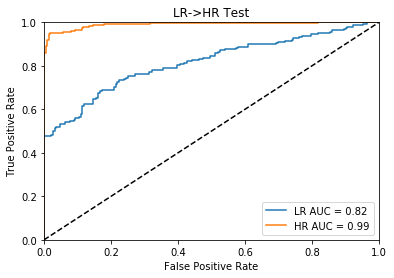

In [25]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000,
        'base_model': 'batch_lr_train-base_train_1_013cced594.pt'}

model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR->HR')

## Testing HR-LR

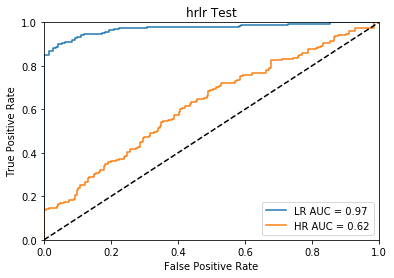

In [5]:
plot_test_roc('hrlr', {'LR': test_lr, 'HR': test_hr}, device)

# Continous training random cache

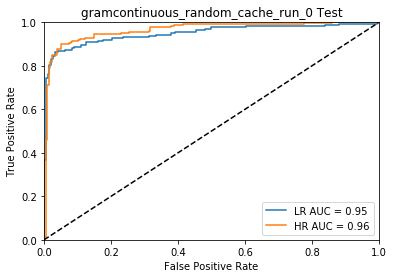

In [10]:
plot_test_roc_gram('gramcontinuous_random_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

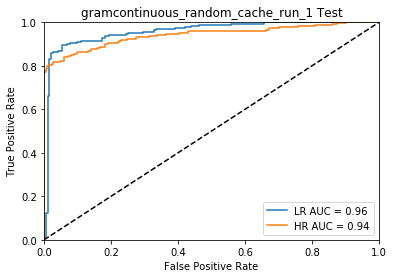

In [9]:
plot_test_roc_gram('gramcontinuous_random_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

# continous without cache

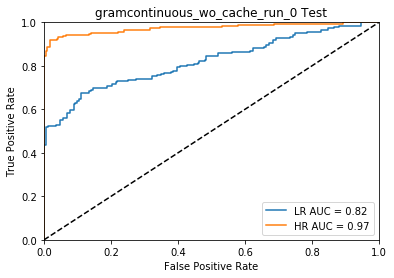

In [5]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

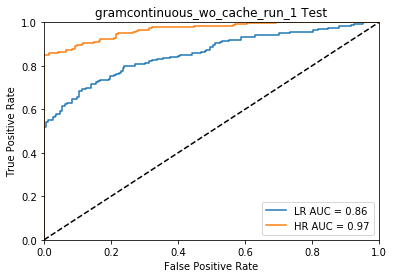

In [6]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

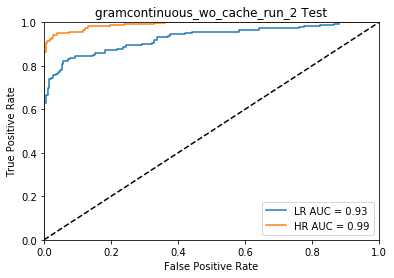

In [7]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_2', {'LR': test_lr, 'HR': test_hr}, device)

# Result Figures

In [130]:
schedule = False
hparams={'continous':False,
         'datasetfile': 'catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
if schedule:
    slurm.srun(catsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = catsmodel.trained_model(hparams)
hparams['datasetfile'] = 'catsinom_hr_dataset.csv'
if schedule:
    slurm.srun(catsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_hr = catsmodel.trained_model(hparams)

Read: /project/catinous/trained_models/batch_lr_base_train_1_2d20289ac9.pt
Read: /project/catinous/trained_models/batch_hr_base_train_1_98bf44d0f0.pt


In [131]:
basemodel_lr

'batch_lr_base_train_1_2d20289ac9.pt'

In [374]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not catsmodel.is_cached(base_params[-1]):
#             slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)  
            print('skip model because not here')
        else:
            _, df_temp, _, _ = catsmodel.trained_model(base_params[-1])
            df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

In [377]:
#data = 'catsinom_combined_hrlowshift_dataset.csv'
# data = 'catsinom_combined_dataset.csv'
data = 'catsinom_combined_dsts3_dataset.csv'

# df_randomcache = pd.DataFrame()
hparams={'continous': True,
         'force_misclassified': True,
         'datasetfile': data,
         'base_model': basemodel_lr,
         'val_check_interval': 30,
         'cachemaximum': 64}
df_randomcache = res_data_for_params(hparams)
              
# df_wo_cache = pd.DataFrame()
hparams={'continous': True,
         'use_cache': False,
         'datasetfile': data,
         'base_model': basemodel_lr,
         'val_check_interval': 30}
df_wo_cache = res_data_for_params(hparams)

INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_c2db0fcf2f.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_2db419ffa0.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_6dc695755a.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_c764513b18.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 64
INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_d0e2cf2e37.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_d932962d94.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_90c7c94bce.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_f6ef5fb3df.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_c38cac9bb6.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_d2b2d48020.pt


In [228]:
hparams={'continous': True,
         'use_cache': False,
         'datasetfile': data,
         'base_model': basemodel_lr,
         'EWC': True,
         'EWC_dataset': 'catsinom_lr_dataset.csv',
         'EWC_lambda': 1000,
         'EWC_bn_off': True,
         'val_check_interval': 30}
df_ewc_bnoff = res_data_for_params(hparams)

hparams={'continous': True,
         'use_cache': False,
         'datasetfile': data,
         'base_model': basemodel_lr,
         'EWC': True,
         'EWC_dataset': 'catsinom_lr_dataset.csv',
         'EWC_lambda': 1000,
         'EWC_bn_off': False,
         'val_check_interval': 30}
df_ewc = res_data_for_params(hparams)

Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_42c71d0e24.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_57e7fbd4f0.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_3f5b9406d3.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_0defa17db3.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_2abc9ee01f.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_1_4315d3eb80.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_2_47ee6875a4.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_3_3c7dadcfb5.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_4_96760cfc4d.pt
Read: /project/catinous/trained_models/cont_combined_basemodel_lr_nocache_tf07_5_f240b04760.pt


In [240]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dsts2_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'hr'
res[streamedDS.df.res == 'hr_ts'] = 2

In [241]:
newcmp = ListedColormap([sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]], name='OrangeBlue')

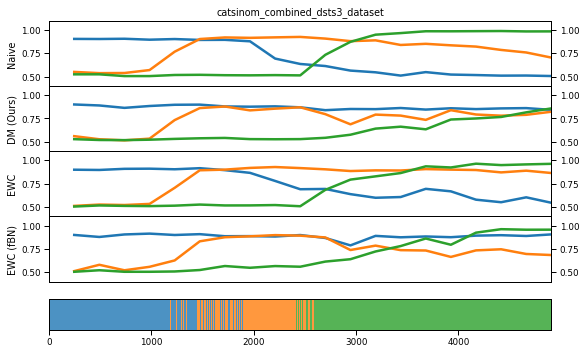

In [384]:
sns.set_context("paper", font_scale=1.0, rc={"lines.linewidth": 2.5})

fig, ax = plt.subplots(5,1, figsize=(9, 6))

plt.subplots_adjust(hspace=0.0)

err_style = None

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0], err_style=err_style)
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0], err_style=err_style)
if 'val_acc_hr_ts' in df_wo_cache:
    sns.lineplot(data=df_wo_cache, y='val_acc_hr_ts', x='idx', ax=ax[0], err_style=err_style)
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 20)
ax[0].set_ylim(.4, 1.1)
ax[0].set_yticks([0.5, 0.75, 1])
ax[0].tick_params(labelright=True, right=True)
ax[0].set_ylabel('Naive')
ax[0].set_title(data.split('.')[0])


sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1], err_style=err_style)
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1], err_style=err_style)
if 'val_acc_hr_ts' in df_randomcache:
    sns.lineplot(data=df_randomcache, y='val_acc_hr_ts', x='idx', ax=ax[1], err_style=err_style)
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 20)
ax[1].set_ylim(.4, 1.1)
ax[1].set_yticks([0.5, 0.75, 1])
ax[1].tick_params(labelright=True, right=True)
ax[1].set_ylabel('DM (Ours)')

sns.lineplot(data=df_ewc, y='val_acc_lr', x='idx', ax=ax[2], err_style=err_style)
sns.lineplot(data=df_ewc, y='val_acc_hr', x='idx', ax=ax[2], err_style=err_style)
if 'val_acc_hr_ts' in df_ewc:
    sns.lineplot(data=df_ewc, y='val_acc_hr_ts', x='idx', ax=ax[2], err_style=err_style)
ax[2].get_xaxis().set_visible(False)
ax[2].set_xlim(0, 20)
ax[2].set_ylim(.4, 1.1)
ax[2].set_yticks([0.5, 0.75, 1])
ax[2].tick_params(labelright=True, right=True)
ax[2].set_ylabel('EWC')

sns.lineplot(data=df_ewc_bnoff, y='val_acc_lr', x='idx', ax=ax[3], err_style=err_style)
sns.lineplot(data=df_ewc_bnoff, y='val_acc_hr', x='idx', ax=ax[3], err_style=err_style)
if 'val_acc_hr_ts' in df_ewc_bnoff:
    sns.lineplot(data=df_ewc_bnoff, y='val_acc_hr_ts', x='idx', ax=ax[3], err_style=err_style)
ax[3].get_xaxis().set_visible(False)
ax[3].set_xlim(0, 20)
ax[3].set_yticks([0.5, 0.75, 1])
ax[3].tick_params(labelright=True, right=True)
ax[3].set_ylim(.4, 1.1)
ax[3].set_ylabel('EWC (fBN)')

ax[4].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[4].get_yaxis().set_visible(False)
ax[4].get_yaxis()

plt.savefig(cutils.RESPATH+data.split('.')[0] + '.pdf')

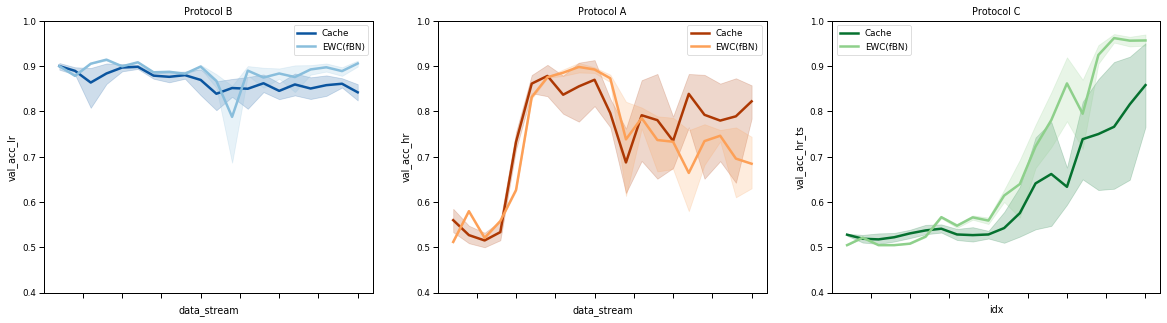

In [379]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', color=sns.color_palette("Blues")[5], ax=ax[0])
sns.lineplot(data=df_ewc_bnoff, y='val_acc_lr', x='idx', color=sns.color_palette("Blues")[2], ax=ax[0])
ax[0].set_xlabel('data_stream')
ax[0].set_xticklabels([])
ax[0].set_ylim(.4, 1)
ax[0].legend(['Cache','EWC(fBN)'])
ax[0].set_title('Protocol B')
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', color=sns.color_palette("Oranges")[5], ax=ax[1])
sns.lineplot(data=df_ewc_bnoff, y='val_acc_hr', x='idx', color=sns.color_palette("Oranges")[2], ax=ax[1])
ax[1].set_xlabel('data_stream')
ax[1].set_xticklabels([])
ax[1].set_ylim(.4, 1)
ax[1].legend(['Cache','EWC(fBN)'])
ax[1].set_title('Protocol A')
sns.lineplot(data=df_randomcache, y='val_acc_hr_ts', x='idx', color=sns.color_palette("Greens")[5], ax=ax[2])
sns.lineplot(data=df_ewc_bnoff, y='val_acc_hr_ts', x='idx', color=sns.color_palette("Greens")[2], ax=ax[2])
ax[1].set_xlabel('data_stream')
ax[2].set_xticklabels([])
ax[2].set_ylim(.4, 1)
ax[2].legend(['Cache','EWC(fBN)'])
ax[2].set_title('Protocol C')
plt.savefig(cutils.RESPATH+'Cache_ewsfBN_comparison'+data.split('.')[0]+'.pdf')

## Cache size

Recompute: /home/jhofmanninger/zzz/__main__.res_data_for_params_79e8315e46710c86753b74cace151f8e4e5c0155.p 

INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_7235b7f5fc.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_c8ca05516c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_2c27a3736a.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_2733085f23.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_5084345c31.pt
in: 10.15s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_e7fb4c155bdca96a1437e734f55f4340e7b774d9.p in: 0.00s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_0a805be4191280e7f1e1bc2f1708b10de4dd5c38.p in: 0.01s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_9907e3140e176da847609e5030694d1f6f1e5fff.p in: 0.02s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_7be14fd5ea90d2e79c1575b3c7f03b28c2da6703.p in: 0.00s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_b8c699c072f47b0f711002832eff0028cab5ffdb.p in: 0.01s
Recompute: /home/jhofmanninger/zzz/__main__.res_data_for_params_f2467c8a76caab85a0b7bbcafc2b96e2c0a3406c.p 

INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_32a9111252.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_2_9e180f6c6c.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_3_41eea41868.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_4_f28b758b71.pt


INFO:root:Gram hooks and cache initialized. Cachesize: 16
INFO:root:Gram hooks and cache initialized. Cachesize: 16


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_5_555c53b743.pt
in: 10.21s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_4bfddc459c5f3d914af0a69aa22465c41a2a325a.p in: 0.00s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_20a1d0d00816128162de42408da28730f1149cf2.p in: 0.01s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_2cd83d5197a6081e8eebb3ef39292ece4aeda04a.p in: 0.01s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_cf43d7468b9a4baef35602c6b87d8937de763cac.p in: 0.01s
Load: /home/jhofmanninger/zzz/__main__.res_data_for_params_cc5bb16ff12e6742b34a2103d68238b46910292f.p in: 0.01s


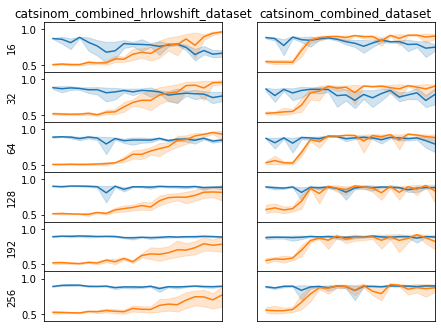

In [197]:
# lambdas = [1, 1000, 10000, 100000]
# lambdas = [1, 1000, 10000]
c_sizes = [16, 32, 64, 128, 192, 256]
datas = ['catsinom_combined_hrlowshift_dataset.csv','catsinom_combined_dataset.csv']
fig, ax = plt.subplots(6,2, figsize=(7, 5.5))
plt.subplots_adjust(hspace=0.0)
for i, data in enumerate(datas):
    for j, c_size in enumerate(c_sizes):
        hparams={'continous': True,
                 'force_misclassified': True,
                 'datasetfile': data,
                 'base_model': basemodel_lr,
                 'val_check_interval': 30,
                 'cachemaximum': c_size}
        t_ews_res = cache.cache(res_data_for_params,hparams)
        
        axis = ax[j,i]
        sns.lineplot(data=t_ews_res, y='val_acc_lr', x='idx', ax=axis)
        sns.lineplot(data=t_ews_res, y='val_acc_hr', x='idx', ax=axis)
        axis.get_xaxis().set_visible(False)
        axis.set_xlim(0, 20)
        axis.set_ylim(.4, 1.1)
        axis.set_ylabel('')
        if i == 0:
            axis.set_ylabel(r'%i' % c_size)
            if j == 0:
                axis.set_title(data.split('.')[0])
        elif j == 0:
            axis.set_title(data.split('.')[0])
        if i == 1:
            axis.get_yaxis().set_visible(False)
        axis.get_xaxis().set_visible(False)

plt.savefig(cutils.RESPATH+'cache_size_effect.pdf')      

## EWC BN effect

In [ ]:
lambdas = [1, 1000, 10000, 100000]
# lambdas = [1, 1000, 10000]
datas = ['catsinom_combined_hrlowshift_dataset.csv','catsinom_combined_dataset.csv']
fig, ax = plt.subplots(4,2, figsize=(7, 5))
plt.subplots_adjust(hspace=0.0)

for i, data in enumerate(datas):
    for j, ewclambda in enumerate(lambdas):
        hparams={'continous': True,
                 'use_cache': False,
                 'datasetfile': data,
                 'base_model': basemodel_lr,
                 'EWC': True,
                 'EWC_dataset': 'catsinom_lr_dataset.csv',
                 'EWC_lambda': ewclambda,
                 'EWC_bn_off': False,
                 'val_check_interval': 30}
        t_ews_res = res_data_for_params(hparams)
        
        axis = ax[j,i]
        sns.lineplot(data=t_ews_res, y='val_acc_lr', x='idx', ax=axis)
        sns.lineplot(data=t_ews_res, y='val_acc_hr', x='idx', ax=axis)
        axis.get_xaxis().set_visible(False)
        axis.set_xlim(0, 20)
        axis.set_ylim(.4, 1.1)
        axis.set_ylabel('')
        if i == 0:
            axis.set_ylabel(r'$\lambda=%.0E$' % ewclambda)
            if j == 0:
                axis.set_title(data.split('.')[0])
        elif j == 0:
            axis.set_title(data.split('.')[0])
        if i == 1:
            axis.get_yaxis().set_visible(False)
        axis.get_xaxis().set_visible(False)

plt.savefig(cutils.RESPATH+'EWC_withbn_effect.pdf')      

# Analyze Cache

In [119]:
def plot_cache_imgs(df):
    imgs = []
    if 'filepath' in df:
        paths = df.filepath
    else:
        paths = df.image
        
    for fp in paths:
        simg = sitk.ReadImage(os.path.join('/project/catinous/cat_data', fp))
        img = sitk.GetArrayFromImage(simg)

        img = mut.intensity_window(img, low=-1024, high=400)
        img = mut.norm01(img)
        imgs.append(img[0])

    mut.mimshow(np.asarray(imgs), nslic=len(df))

In [ ]:
def plot_random_cache_imgs():
    imgs = []
    for fp in df.filepath:
        simg = sitk.ReadImage(os.path.join('/project/catinous/cat_data', fp))
        img = sitk.GetArrayFromImage(simg)

        img = mut.intensity_window(img, low=-1024, high=400)
        img = mut.norm01(img)
        imgs.append(img[0])

    mut.mimshow(np.asarray(imgs), nslic=len(df))

In [107]:
hparams={'continous': True,
         'force_misclassified': True,
         'datasetfile': data,
         'base_model': basemodel_lr,
         'val_check_interval': 30,
         'cachemaximum': 64,
         'run_postfix': 1}
_, _, df_cache, _ = catsmodel.trained_model(hparams)

INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_f1ea67da01.pt


In [62]:
# df_cache = pd.read_csv('/project/catinous/trained_cache/continous_random_cache_cachesize_128_run_0.csv')

In [108]:
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr,22,22,22
lr,42,42,42


In [110]:
df_cache.groupby('label').count()

,filepath,res,traincounter
label,,,
0,32,32,32
1,32,32,32


In [ ]:
plot_cache_imgs(df_cache)
plt.savefig(cutils.RESPATH+'cache_hterogeneity.pdf')

In [118]:
plot_cache_imgs(pd.read_csv(data))


,filepath,label,res,traincounter
0,hr_cat_lowshift/06L4Y1BK_20140414_dicom_268776...,1,hr,0
1,lr/940C933D_20140102_dicom_13846.dcm,0,lr,47
2,hr/08EIAPBK_20150103_dicom_255601.dcm,0,hr,0
3,lr/271B9E0C_20090817_dicom_11236.dcm,0,lr,58
4,hr/1KK7CVC4_20131127_dicom_302009.dcm,0,hr,40
...,...,...,...,...
59,lr_cat/B9032239_20080721_dicom_88615.dcm,1,lr,27
60,lr/CD357380_20130131_dicom_83718.dcm,0,lr,48
61,lr/C1795C5F_20131111_dicom_91365.dcm,0,lr,41
62,lr_cat/7227E566_20051222_dicom_13554.dcm,1,lr,33


In [ ]:
plot_cache_imgs(pd.read_csv(data).sample(64))
plt.savefig(cutils.RESPATH+'random_cases.pdf')

### Illustrate data

In [313]:
import imageio

In [ ]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dsts2_dataset.csv', transition_phase_after=0.7, direction='lr->hr')

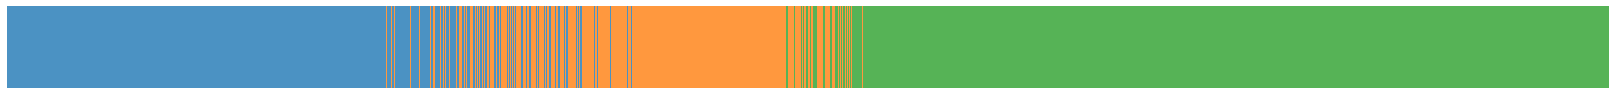

In [347]:
res = streamedDS.df.res == 'hr'
res[streamedDS.df.res == 'hr_ts'] = 2
plt.figure(figsize=(30,1.5))
plt.imshow(np.tile(res,(250,1)), cmap=newcmp, alpha=0.8)
plt.axis('off')
imageio.imwrite(cutils.RESPATH + 'continous3classes.png', np.asarray(newcmp.colors)[np.tile(res,(250,1)).astype(int),:])

In [274]:
data = 'catsinom_combined_dsts2_dataset.csv'
cont_data = pd.read_csv(data, index_col=0)
am = cont_data.query('res == "lr" and label == 0')
ap = cont_data.query('res == "lr" and label == 1')
bm = cont_data.query('res == "hr" and label == 0')
bp = cont_data.query('res == "hr" and label == 1')
cm = cont_data.query('res == "hr_ts" and label == 0')
cp = cont_data.query('res == "hr_ts" and label == 1')

In [348]:
simg = sitk.ReadImage('/project/catinous/cat_data/' + am.image.iloc[0])
img_am = sitk.GetArrayFromImage(simg)[0]
img_am = mut.intensity_window(img_am, high=100)
imageio.imwrite(cutils.RESPATH + 'img_am.png', img_am)

simg = sitk.ReadImage('/project/catinous/cat_data/' + ap.image.iloc[0])
img_ap = sitk.GetArrayFromImage(simg)[0]
img_ap = mut.intensity_window(img_ap, high=100)
imageio.imwrite(cutils.RESPATH + 'img_ap.png', img_ap)

simg = sitk.ReadImage('/project/catinous/cat_data/' + bm.image.iloc[0])
img_bm = sitk.GetArrayFromImage(simg)[0]
img_bm = mut.intensity_window(img_bm, high=100)
imageio.imwrite(cutils.RESPATH + 'img_bm.png', img_bm)

simg = sitk.ReadImage('/project/catinous/cat_data/' + bp.image.iloc[2])
img_bp = sitk.GetArrayFromImage(simg)[0]
img_bp = mut.intensity_window(img_bp, high=100)
imageio.imwrite(cutils.RESPATH + 'img_bp.png', img_bp)

simg = sitk.ReadImage('/project/catinous/cat_data/' + cm.image.iloc[0])
img_cm = sitk.GetArrayFromImage(simg)[0]
img_cm = mut.intensity_window(img_cm, high=100)
imageio.imwrite(cutils.RESPATH + 'img_cm.png', img_cm)

simg = sitk.ReadImage('/project/catinous/cat_data/' + cp.image.iloc[2])
img_cp = sitk.GetArrayFromImage(simg)[0]
img_cp = mut.intensity_window(img_cp, high=100)
imageio.imwrite(cutils.RESPATH + 'img_cp.png', img_cp)

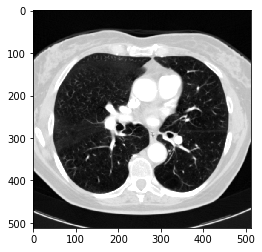

In [301]:
plt.imshow(img_am)

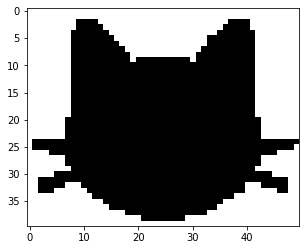

In [320]:
cpic = np.load('data_prep/catpic.npy')
cpicb = np.abs(cpic-255)
plt.imshow(cpicb)
imageio.imwrite(cutils.RESPATH + '/catwhite.png', cpic)
imageio.imwrite(cutils.RESPATH + '/catblack.png', cpicb)